In [1]:
!pip install category_encoders
!pip install pdpbox==0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pdpbox: filename=PDPbox-0.2.0-py3-none-any.whl size=57690721 sha256=535fd3b80268613861e192abe332c4b54b5ee6c2d6b2afb674fed097dd743831
  Stored in directory: /root/.cache/pip/wheels/96/52/0a/c66141e9ac8c6bd7ccc2170d835b827ba7ca16de4960c2a04c
Successfully built pdpbox


In [1]:
!pip3 install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107747 sha256=f086c3a2aabae579233c3ffda54b8c995b2f91d50db41e1ae26ce2cd448c2fea
  Stored in directory: /root/.cache/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5


from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import display, HTML
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler

In [8]:
from google.colab import files
uploaded = files.upload()

Saving paramount_titles.csv to paramount_titles.csv


In [115]:
disney_titles = pd.read_csv('titles.csv')
amazon_titles = pd.read_csv('amazon_titles.csv')
apple_titles = pd.read_csv('apple_titles.csv')
HBO_titles = pd.read_csv('HBO_titles.csv')
netflix_titles = pd.read_csv('netflix_titles.csv')
paramount_titles = pd.read_csv('paramount_titles.csv')

In [116]:
disney_titles['platform'] = 'disney'  # 파일을 합칠 때 서로 미디어 구분을 위해 새 컬럼인 어떤 플랫폼인지를 나타내는 새 플랫폼 컬럼을 생성
amazon_titles['platform'] = 'amazon'
apple_titles['platform'] = 'apple'
HBO_titles['platform'] = 'HBO'
netflix_titles['platform'] = 'netflix'
paramount_titles['platform'] = 'paramount'

In [117]:
ott_media = pd.concat([disney_titles, amazon_titles, apple_titles, HBO_titles, netflix_titles, paramount_titles])
ott_media = ott_media.reset_index(drop=True)

In [118]:
ott_media[ott_media.duplicated() == False] # 중복치 데이터 제거

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,platform
0,tm89464,Miracle on 34th Street,MOVIE,"Kris Kringle, seemingly the embodiment of Sant...",1947,G,96,"['family', 'comedy', 'drama']",['US'],NaN,tt0039628,7.9,50969.0,23.515,7.388,disney
1,tm61729,The Adventures of Ichabod and Mr. Toad,MOVIE,The Wind in the Willows: Concise version of Ke...,1950,G,68,"['horror', 'fantasy', 'animation', 'family', '...",['US'],NaN,tt0041094,6.9,16502.0,16.194,6.500,disney
2,tm61052,Cinderella,MOVIE,Cinderella has faith her dreams of a better li...,1950,G,74,"['fantasy', 'animation', 'family', 'romance']",['US'],NaN,tt0042332,7.3,164292.0,93.547,7.035,disney
3,tm87946,Dumbo,MOVIE,Dumbo is a baby elephant born with over-sized ...,1941,G,64,"['animation', 'drama', 'family', 'fantasy']",['US'],NaN,tt0033563,7.2,135045.0,54.265,6.999,disney
4,tm74391,Fantasia,MOVIE,Walt Disney's timeless masterpiece is an extra...,1941,G,119,"['animation', 'family', 'fantasy', 'music']",['US'],NaN,tt0032455,7.7,98764.0,43.609,7.382,disney
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25241,ts374339,Sometimes When We Touch,SHOW,"The untold story of soft rock, whose artists d...",2023,TV-MA,48,"['documentation', 'history', 'music']",['US'],1.0,tt24512706,7.7,91.0,4.342,2.000,paramount
25242,ts361945,FBI True,SHOW,Takes viewers behind the scenes of the most co...,2023,TV-14,24,"['drama', 'documentation']",['US'],1.0,tt26895624,6.9,25.0,7.531,NaN,paramount
25243,ts378319,Lingo,SHOW,Host RuPaul Charles brings his one-of-a-kind p...,2023,NaN,42,['reality'],['US'],1.0,tt26082946,5.7,76.0,2.751,2.000,paramount
25244,tm1075680,World's Most Dangerous Shark?,MOVIE,"The Great White has a scary reputation, but Ex...",2023,PG-13,44,['documentation'],[],NaN,NaN,NaN,NaN,1.623,NaN,paramount


In [73]:
ott_media.genres.unique()

array(["['family', 'comedy', 'drama']",
       "['horror', 'fantasy', 'animation', 'family', 'comedy']",
       "['fantasy', 'animation', 'family', 'romance']", ...,
       "['documentation', 'war', 'crime', 'history']",
       "['romance', 'scifi', 'fantasy']",
       "['action', 'fantasy', 'comedy', 'drama', 'romance', 'thriller']"],
      dtype=object)

In [74]:
ott_media.production_countries.unique()

array(["['US']", "['GB', 'US']", "['GB']", ...,
       "['SE', 'GB', 'IE', 'US']", "['NZ', 'CA']",
       "['US', 'KH', 'PK', 'GB']"], dtype=object)

In [119]:
# 시즌 컬럼을 볼 때 무비 타입은 시즌이 없기 때문에 널로 취급한 걸로 보임
# 따라서 무비의 시즌의 결측치는 0으로 대체함.
ott_media['seasons'] = ott_media['seasons'].fillna(0)

In [120]:
# 장르와 생산 국가가 결측치 값이 존재하는데 결측치를 채우기 위해 다른 값으로 대체하거나 0으로 하는 것은
# 장르 데이터 특성 상 어색하기 때문에 따라서 이에 관련된 행은 삭제.
ott_media['genres'] = ott_media['genres'].str.extract('(\w+)')
ott_media['production_countries'] = ott_media['production_countries'].str.extract('(\w+)')

In [121]:
ott_media = ott_media[ott_media['genres'].isnull() == False]
ott_media.reset_index(drop=True)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,platform
0,tm89464,Miracle on 34th Street,MOVIE,"Kris Kringle, seemingly the embodiment of Sant...",1947,G,96,family,US,0.0,tt0039628,7.9,50969.0,23.515,7.388,disney
1,tm61729,The Adventures of Ichabod and Mr. Toad,MOVIE,The Wind in the Willows: Concise version of Ke...,1950,G,68,horror,US,0.0,tt0041094,6.9,16502.0,16.194,6.500,disney
2,tm61052,Cinderella,MOVIE,Cinderella has faith her dreams of a better li...,1950,G,74,fantasy,US,0.0,tt0042332,7.3,164292.0,93.547,7.035,disney
3,tm87946,Dumbo,MOVIE,Dumbo is a baby elephant born with over-sized ...,1941,G,64,animation,US,0.0,tt0033563,7.2,135045.0,54.265,6.999,disney
4,tm74391,Fantasia,MOVIE,Walt Disney's timeless masterpiece is an extra...,1941,G,119,animation,US,0.0,tt0032455,7.7,98764.0,43.609,7.382,disney
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24868,ts374339,Sometimes When We Touch,SHOW,"The untold story of soft rock, whose artists d...",2023,TV-MA,48,documentation,US,1.0,tt24512706,7.7,91.0,4.342,2.000,paramount
24869,ts361945,FBI True,SHOW,Takes viewers behind the scenes of the most co...,2023,TV-14,24,drama,US,1.0,tt26895624,6.9,25.0,7.531,NaN,paramount
24870,ts378319,Lingo,SHOW,Host RuPaul Charles brings his one-of-a-kind p...,2023,NaN,42,reality,US,1.0,tt26082946,5.7,76.0,2.751,2.000,paramount
24871,tm1075680,World's Most Dangerous Shark?,MOVIE,"The Great White has a scary reputation, but Ex...",2023,PG-13,44,documentation,NaN,0.0,NaN,NaN,NaN,1.623,NaN,paramount


In [77]:
print(ott_media.genres.unique())
print(ott_media.production_countries.unique())

['family' 'horror' 'fantasy' 'animation' 'comedy' 'thriller' 'romance'
 'action' 'documentation' 'crime' 'western' 'drama' 'scifi' 'history'
 'music' 'reality' 'sport' 'war' 'european']
['US' 'GB' 'CA' nan 'FR' 'SE' 'AU' 'SK' 'ES' 'JP' 'PL' 'IN' 'CN' 'BR' 'DE'
 'NZ' 'AR' 'CI' 'NL' 'AE' 'KR' 'IT' 'CO' 'ZA' 'CL' 'AT' 'PH' 'BW' 'GR'
 'TW' 'MX' 'DK' 'TR' 'PR' 'SU' 'MA' 'HK' 'IE' 'CH' 'RO' 'YU' 'MC' 'IL'
 'EG' 'RU' 'LI' 'IR' 'PT' 'BE' 'FI' 'ID' 'VE' 'XC' 'NO' 'BG' 'TH' 'LU'
 'DO' 'JM' 'IS' 'RS' 'CZ' 'SG' 'HU' 'LT' 'UA' 'KZ' 'NG' 'UY' 'MT' 'AF'
 'VN' 'KE' 'BO' 'GE' 'TT' 'BY' 'MY' 'PK' 'PE' 'XK' 'TC' 'LB' 'NP' 'MN'
 'NI' 'SB' 'CR' 'PA' 'UZ' 'NA' 'KH' 'QA' 'CM' 'EE' 'CU' 'LV' 'SY' 'BM'
 'IO' 'PF' 'HN' 'TN' 'EC' 'BD' 'MK' 'DZ' 'SN' 'GT' 'ET' 'PS' 'SA' 'CD'
 'GL' 'JO' 'KW' 'PY' 'IQ' 'TZ' 'KG' 'BT' 'AO' 'GH' 'ZW' 'MW' 'MU' 'FO'
 'ZM' 'BS']


In [79]:
ott_media.platform.unique()

array(['disney', 'amazon', 'apple', 'HBO', 'netflix', 'paramount'],
      dtype=object)

In [ ]:
ott_media.isnull().sum()

id                          0
title                       0
type                        0
description               164
release_year                0
age_certification       12879
runtime                     0
genres                      0
production_countries      898
seasons                     0
imdb_id                  1759
imdb_score               2308
imdb_votes               2360
tmdb_popularity           642
tmdb_score               2885
platform                    0
dtype: int64

In [ ]:
ott_media.describe() # 타겟 대상인 tmdb_popularity 수치가 이상하리만큼 차이가 너무 남. 따라서 이를 조정할 필요가` 있음.

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,24873.000000,24873.000000,24873.000000,22565.000000,2.251300e+04,24231.000000,21988.000000
mean,2005.726852,79.987979,0.600450,6.289306,2.459102e+04,14.237794,6.343601
std,23.598660,36.527805,2.044056,1.288981,1.040939e+05,54.682907,1.401913
min,1901.000000,0.000000,0.000000,1.100000,5.000000e+00,0.000153,0.500000
25%,2004.000000,52.000000,0.000000,5.500000,2.070000e+02,1.912000,5.600000
50%,2016.000000,86.000000,0.000000,6.400000,1.104000e+03,4.466000,6.500000
75%,2020.000000,102.000000,0.000000,7.200000,7.198000e+03,11.820500,7.237000
max,2023.000000,940.000000,53.000000,9.900000,2.684317e+06,3481.253000,10.000000


<Axes: xlabel='imdb_votes', ylabel='Count'>

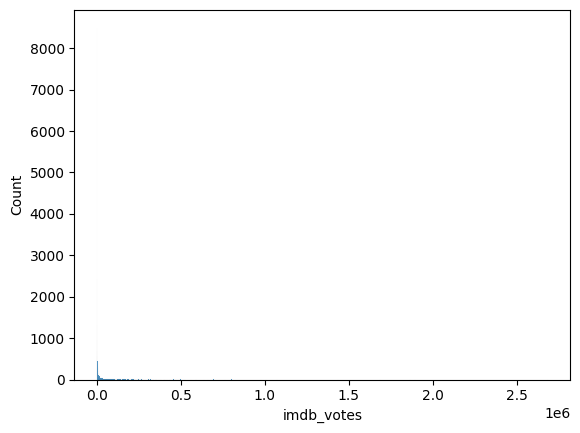

In [ ]:
sns.histplot(ott_media['imdb_votes'])

<Axes: xlabel='runtime', ylabel='Count'>

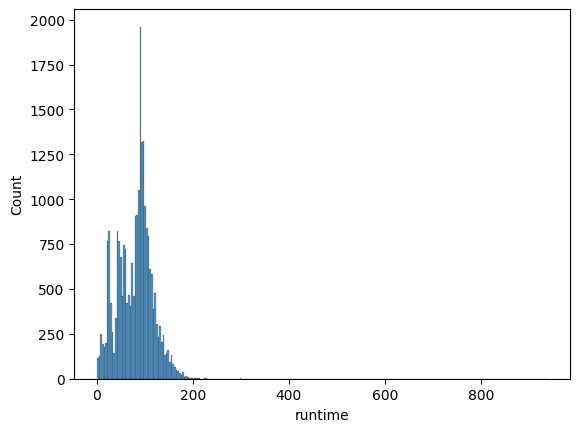

In [ ]:
sns.histplot(ott_media['runtime'])

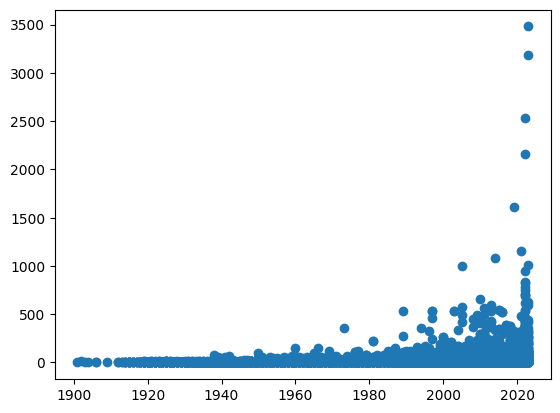

In [83]:
plt.scatter(x=ott_media.release_year, y=ott_media.tmdb_popularity)

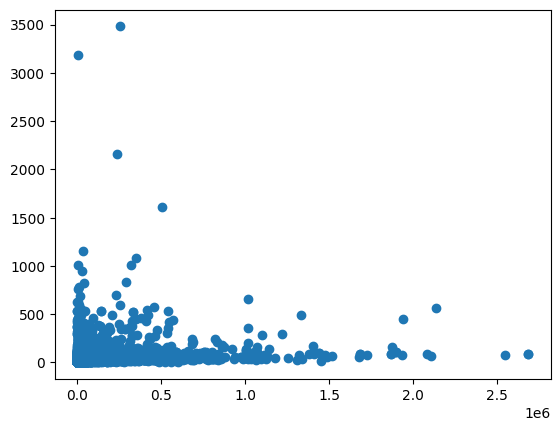

In [80]:
plt.scatter(x=ott_media.imdb_votes, y=ott_media.tmdb_popularity)

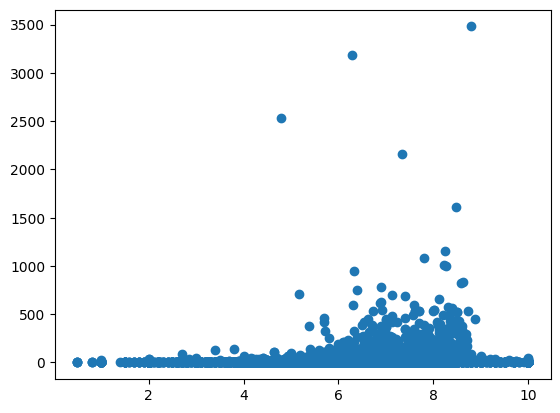

In [85]:
plt.scatter(x=ott_media.tmdb_score, y=ott_media.tmdb_popularity)

In [102]:
Year_genre = pd.pivot_table(ott_media.groupby(['release_year', 'genres'])['tmdb_popularity'].sum().reset_index(), index='release_year', columns='genres', values='tmdb_popularity').fillna(0)[64:]

In [35]:
len(Year_genre.index)

54

In [103]:
Year_genres = pd.DataFrame(columns=['action', 'animation', 'comedy', 'crime', 'documentation', 'drama',
       'european', 'family', 'fantasy', 'history', 'horror', 'music',
       'reality', 'romance', 'scifi', 'sport', 'thriller', 'war', 'western'])

Year_genres1 =  Year_genres

Year_sum = Year_genre.sum(axis=1).unique()

for i in range(54):
  Y2 = Year_genre.iloc[i] / Year_sum[i]
  Year_genres = Year_genres.append(Y2)

for i in range(54):
  Y21 = Year_genres.iloc[i].sort_values(ascending=False)[:3]
  Year_genres1 =Year_genres1.append(Y21)

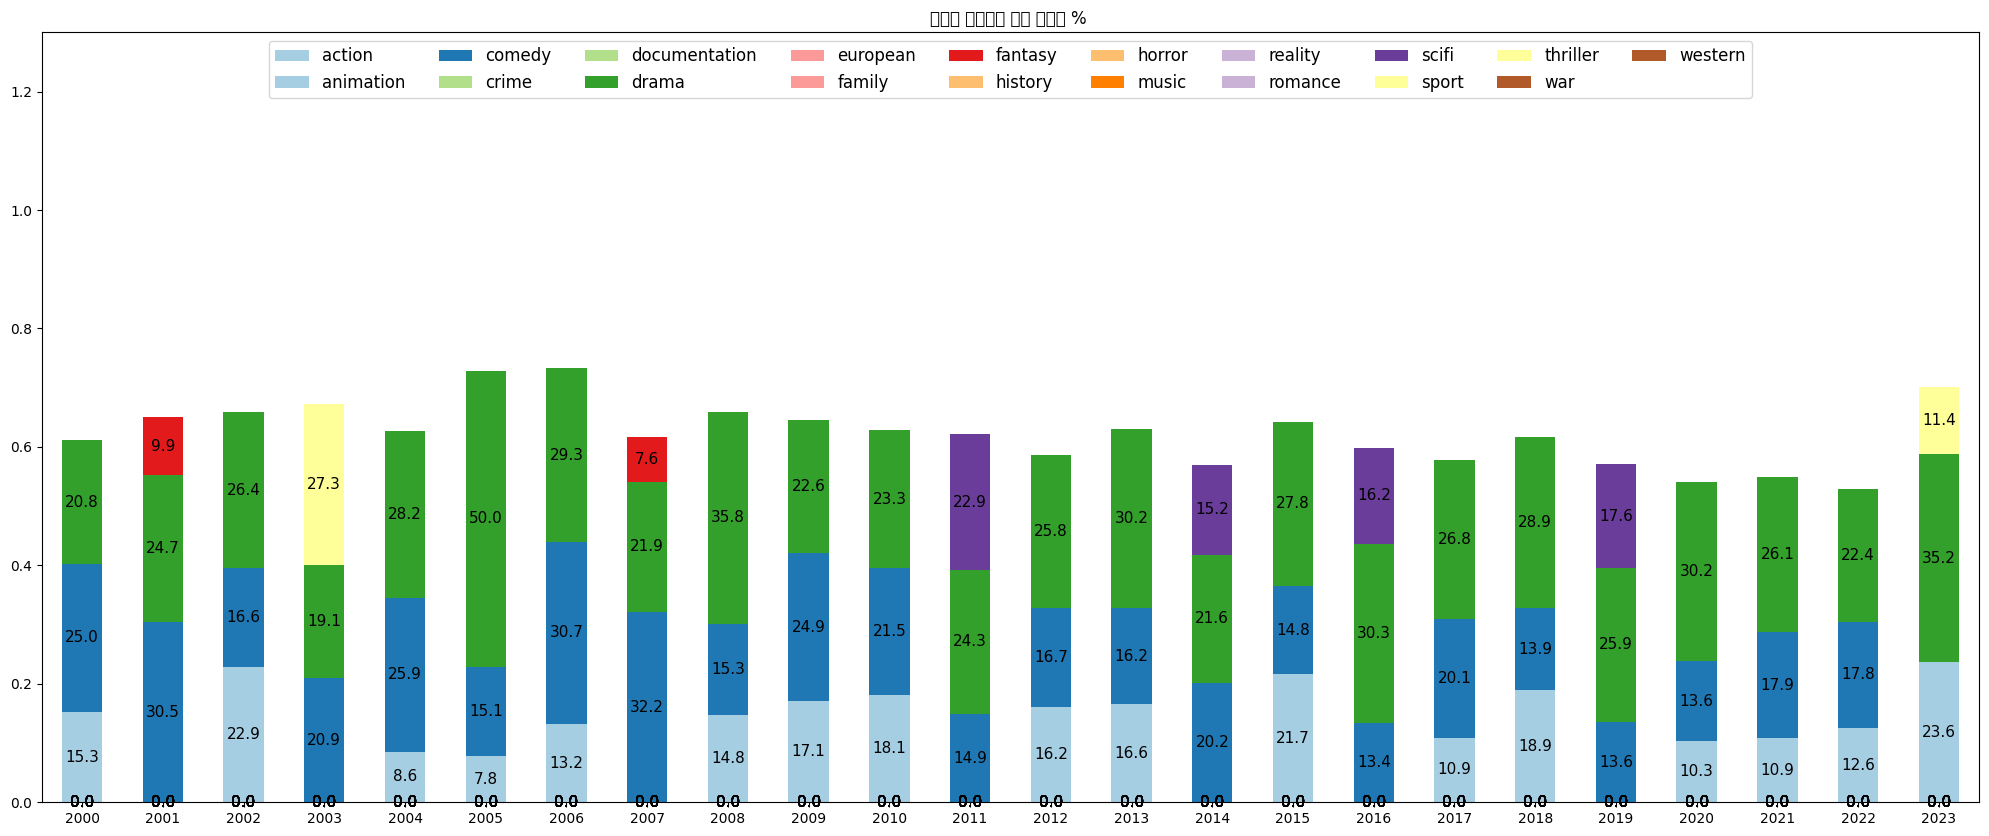

In [93]:
ax = Year_genres1.iloc[30:].plot.bar(ylim=(0,1.3), figsize=(25, 10),stacked=True, title="연도별 출고량에 따른 트렌드 % ", colormap='Paired', rot=0)

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.1f"%(height*100), xy=(left+width/2, bottom+height/2), ha='center', va='center', fontsize=11)
plt.xticks(size=10)
plt.legend(fontsize=12, loc='upper center', ncol=10, bbox_to_anchor=(0.5, 1))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'action'),
  Text(1, 0, 'animation'),
  Text(2, 0, 'comedy'),
  Text(3, 0, 'crime'),
  Text(4, 0, 'documentation'),
  Text(5, 0, 'drama'),
  Text(6, 0, 'european'),
  Text(7, 0, 'family'),
  Text(8, 0, 'fantasy'),
  Text(9, 0, 'history'),
  Text(10, 0, 'horror'),
  Text(11, 0, 'music'),
  Text(12, 0, 'reality'),
  Text(13, 0, 'romance'),
  Text(14, 0, 'scifi'),
  Text(15, 0, 'sport'),
  Text(16, 0, 'thriller'),
  Text(17, 0, 'war'),
  Text(18, 0, 'western')])

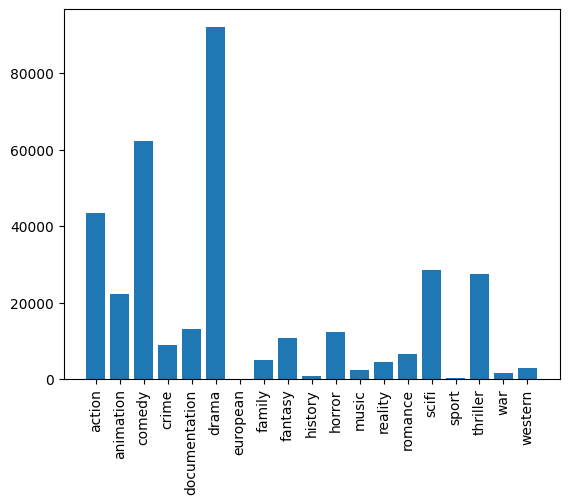

In [ ]:
x = ott_media.groupby('genres')['tmdb_popularity'].sum().index
y = []
for i in range(len(x)):
  ot = ott_media.groupby('genres')['tmdb_popularity'].sum()[i]
  y.append(ot)

plt.bar(x, y)
plt.xticks(rotation=90)

In [122]:
ott_media.drop(['description', 'imdb_id', 'title', 'id'], axis=1, inplace=True)
ott_media

,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,platform
0,MOVIE,1947,G,96,family,US,0.0,7.9,50969.0,23.515,7.388,disney
1,MOVIE,1950,G,68,horror,US,0.0,6.9,16502.0,16.194,6.500,disney
2,MOVIE,1950,G,74,fantasy,US,0.0,7.3,164292.0,93.547,7.035,disney
3,MOVIE,1941,G,64,animation,US,0.0,7.2,135045.0,54.265,6.999,disney
4,MOVIE,1941,G,119,animation,US,0.0,7.7,98764.0,43.609,7.382,disney
...,...,...,...,...,...,...,...,...,...,...,...,...
25241,SHOW,2023,TV-MA,48,documentation,US,1.0,7.7,91.0,4.342,2.000,paramount
25242,SHOW,2023,TV-14,24,drama,US,1.0,6.9,25.0,7.531,NaN,paramount
25243,SHOW,2023,NaN,42,reality,US,1.0,5.7,76.0,2.751,2.000,paramount
25244,MOVIE,2023,PG-13,44,documentation,NaN,0.0,NaN,NaN,1.623,NaN,paramount


In [ ]:
for i in ott_media

KeyError: ignored

In [ ]:
titles = ott_media

In [123]:
titles = ott_media[ott_media['production_countries'].isnull() == False]
titles

,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,platform
0,MOVIE,1947,G,96,family,US,0.0,7.9,50969.0,23.515,7.388,disney
1,MOVIE,1950,G,68,horror,US,0.0,6.9,16502.0,16.194,6.500,disney
2,MOVIE,1950,G,74,fantasy,US,0.0,7.3,164292.0,93.547,7.035,disney
3,MOVIE,1941,G,64,animation,US,0.0,7.2,135045.0,54.265,6.999,disney
4,MOVIE,1941,G,119,animation,US,0.0,7.7,98764.0,43.609,7.382,disney
...,...,...,...,...,...,...,...,...,...,...,...,...
25240,MOVIE,2023,R,100,comedy,US,0.0,5.5,864.0,21.746,5.729,paramount
25241,SHOW,2023,TV-MA,48,documentation,US,1.0,7.7,91.0,4.342,2.000,paramount
25242,SHOW,2023,TV-14,24,drama,US,1.0,6.9,25.0,7.531,NaN,paramount
25243,SHOW,2023,NaN,42,reality,US,1.0,5.7,76.0,2.751,2.000,paramount


In [124]:
titles['seasons'] = titles['seasons'].fillna(0)

In [ ]:
for i in titles.columns:
    titles = titles[titles[i].isnull() == False]


In [125]:
titles.reset_index(drop=True)

,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,platform
0,MOVIE,1947,G,96,family,US,0.0,7.9,50969.0,23.515,7.388,disney
1,MOVIE,1950,G,68,horror,US,0.0,6.9,16502.0,16.194,6.500,disney
2,MOVIE,1950,G,74,fantasy,US,0.0,7.3,164292.0,93.547,7.035,disney
3,MOVIE,1941,G,64,animation,US,0.0,7.2,135045.0,54.265,6.999,disney
4,MOVIE,1941,G,119,animation,US,0.0,7.7,98764.0,43.609,7.382,disney
...,...,...,...,...,...,...,...,...,...,...,...,...
23970,MOVIE,2023,R,100,comedy,US,0.0,5.5,864.0,21.746,5.729,paramount
23971,SHOW,2023,TV-MA,48,documentation,US,1.0,7.7,91.0,4.342,2.000,paramount
23972,SHOW,2023,TV-14,24,drama,US,1.0,6.9,25.0,7.531,NaN,paramount
23973,SHOW,2023,NaN,42,reality,US,1.0,5.7,76.0,2.751,2.000,paramount


In [ ]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23975 entries, 0 to 25245
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  23975 non-null  object 
 1   release_year          23975 non-null  int64  
 2   age_certification     11856 non-null  object 
 3   runtime               23975 non-null  int64  
 4   genres                23975 non-null  object 
 5   production_countries  23975 non-null  object 
 6   seasons               23975 non-null  float64
 7   imdb_score            22037 non-null  float64
 8   imdb_votes            21987 non-null  float64
 9   tmdb_popularity       23582 non-null  float64
 10  tmdb_score            21620 non-null  float64
 11  platform              23975 non-null  object 
dtypes: float64(5), int64(2), object(5)
memory usage: 2.4+ MB


In [ ]:
titles.genres.unique()

array(['family', 'horror', 'fantasy', 'animation', 'comedy', 'thriller',
       'romance', 'action', 'documentation', 'crime', 'western', 'drama',
       'scifi', 'music', 'reality', 'history', 'sport', 'war', 'european'],
      dtype=object)

In [126]:
# 결측치가 많은 행들은 null 값을 가장 높은 빈도 값으로 채우기
def fill_null(df):
  for i in df.columns:
    df_n = df[i].dtypes
    if df_n != object:
      df[i] = df[i].fillna(df[i].mode()[0])
    if df_n == object:
      df[i].fillna(df[i].mode()[0], inplace=True)
    

fill_null(titles)

In [ ]:
movie = titles[titles['type'] == 'MOVIE']
show = titles[titles['type'] == 'SHOW']

In [ ]:
movie.nunique()

type                       1
release_year             118
age_certification          5
runtime                  223
genres                    19
production_countries     126
imdb_score                86
imdb_votes              7596
tmdb_popularity         9782
tmdb_score              2388
platform                   6
dtype: int64

In [ ]:
show.nunique()

type                       1
release_year              76
age_certification          8
runtime                  112
genres                    18
production_countries      61
seasons                   40
imdb_score                80
imdb_votes              3215
tmdb_popularity         4604
tmdb_score              1344
platform                   6
dtype: int64

In [ ]:
movie.drop(['seasons', 'type'], axis=1, inplace=True)
show.drop('type', axis=1, inplace=True)

In [ ]:
movie.describe()

,release_year,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,18431.000000,18431.000000,18431.000000,1.843100e+04,18431.000000,18431.000000
mean,2002.347458,93.426727,6.109815,2.551971e+04,10.976710,6.101059
std,25.966656,30.237633,1.192184,1.091313e+05,44.474120,1.245501
min,1901.000000,2.000000,1.100000,5.000000e+00,0.001609,0.500000
25%,1997.000000,80.000000,5.400000,1.360000e+02,1.723500,5.507500
50%,2015.000000,93.000000,6.300000,8.230000e+02,3.826000,6.100000
75%,2019.000000,108.000000,6.900000,6.251000e+03,9.974000,6.900000
max,2023.000000,940.000000,9.900000,2.684317e+06,3187.531000,10.000000


In [ ]:
show.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5544.000000,5544.000000,5544.000000,5544.000000,5.544000e+03,5544.000000,5544.000000
mean,2015.112193,37.082973,2.658730,7.017262,1.498684e+04,25.496702,7.025714
std,9.492158,17.154664,3.627682,1.095758,6.688816e+04,79.489306,1.328485
min,1934.000000,0.000000,1.000000,1.100000,5.000000e+00,0.050393,0.500000
25%,2014.000000,24.000000,1.000000,6.500000,1.480000e+02,3.199750,6.186500
50%,2018.000000,39.000000,1.000000,7.100000,1.051500e+03,8.456000,7.200000
75%,2021.000000,48.000000,3.000000,7.800000,6.189500e+03,21.831250,7.900000
max,2023.000000,209.000000,53.000000,9.700000,2.134702e+06,3481.253000,10.000000


In [ ]:
show['imdb_votes'].max()

2134702.0

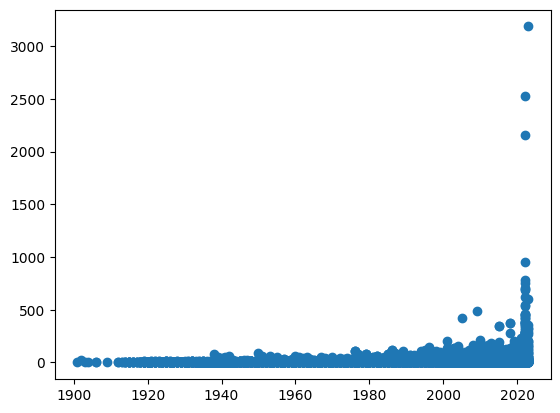

In [ ]:
plt.scatter(x=movie.release_year, y=movie.tmdb_popularity)

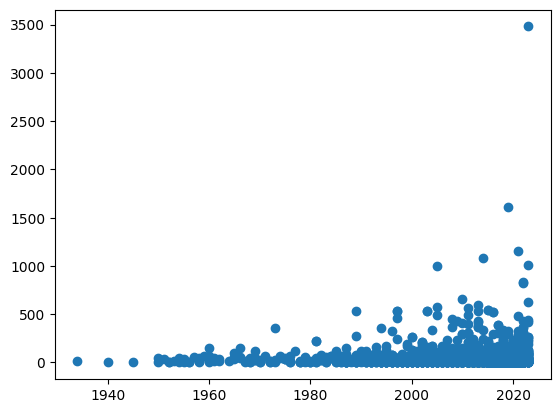

In [ ]:
plt.scatter(x=show.release_year, y=show.tmdb_popularity)

In [ ]:
movie.corr()['tmdb_popularity'].sort_values(ascending=False)

tmdb_popularity    1.000000
imdb_votes         0.217543
tmdb_score         0.103156
runtime            0.082392
release_year       0.071017
imdb_score         0.048985
Name: tmdb_popularity, dtype: float64

<Axes: >

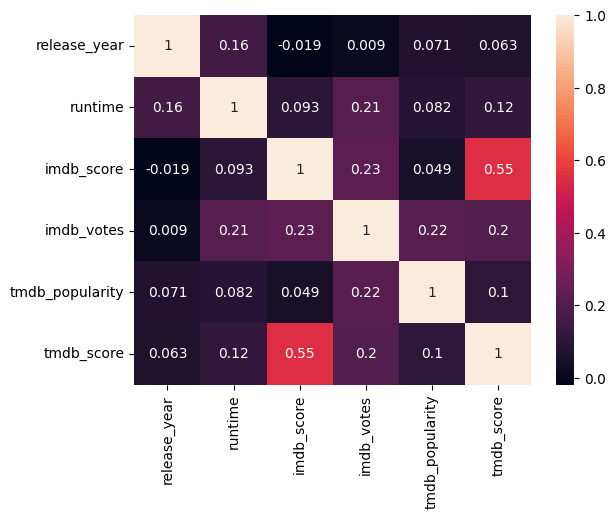

In [ ]:
sns.heatmap(movie.corr(), annot=True)

In [57]:
titles.corr()['tmdb_popularity'].sort_values(ascending=False)

tmdb_popularity    1.000000
imdb_votes         0.403820
tmdb_score         0.260591
imdb_score         0.155442
seasons            0.152268
release_year       0.097103
runtime            0.048555
Name: tmdb_popularity, dtype: float64

<Axes: >

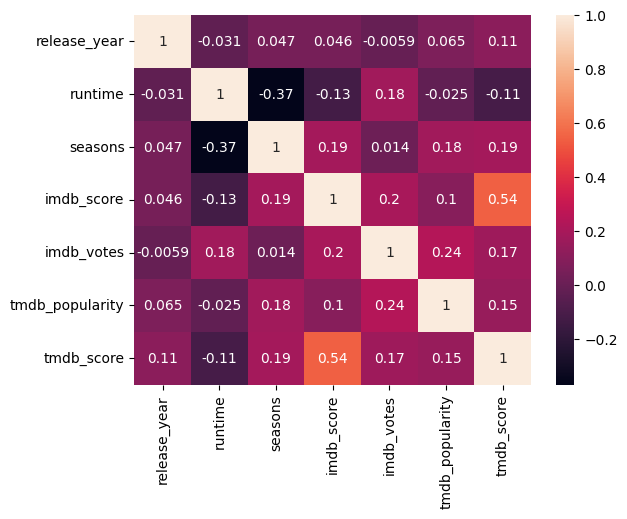

In [109]:
sns.heatmap(titles.corr(), annot=True)

In [ ]:
titles1 = titles[(titles['imdb_votes'] < 1500000)]
titles1 = titles1[(titles1['tmdb_popularity'] < 1300)]
titles1 = titles1[(titles1['runtime'] < 400)]
titles1 = titles1[(titles1['tmdb_score'] > 1)]

In [ ]:
titles1 = titles1[(titles1['tmdb_popularity'] < 900)]
titles1 = titles1[(titles1['runtime'] < 270)]

In [ ]:
titles = titles[(titles['tmdb_popularity'] < 900)]

In [ ]:
titles = titles[(titles['runtime'] < 400)]

In [129]:
def cut_outlier(df, rev_col):
  for i in rev_col:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)

    IQR =  q3 - q1
    df = df[(df[i] < (q3 + IQR)) & (df[i] > (q1 - IQR))]
    df = df.reset_index(drop=True)
    return df

titles = cut_outlier(titles, ['tmdb_popularity'])

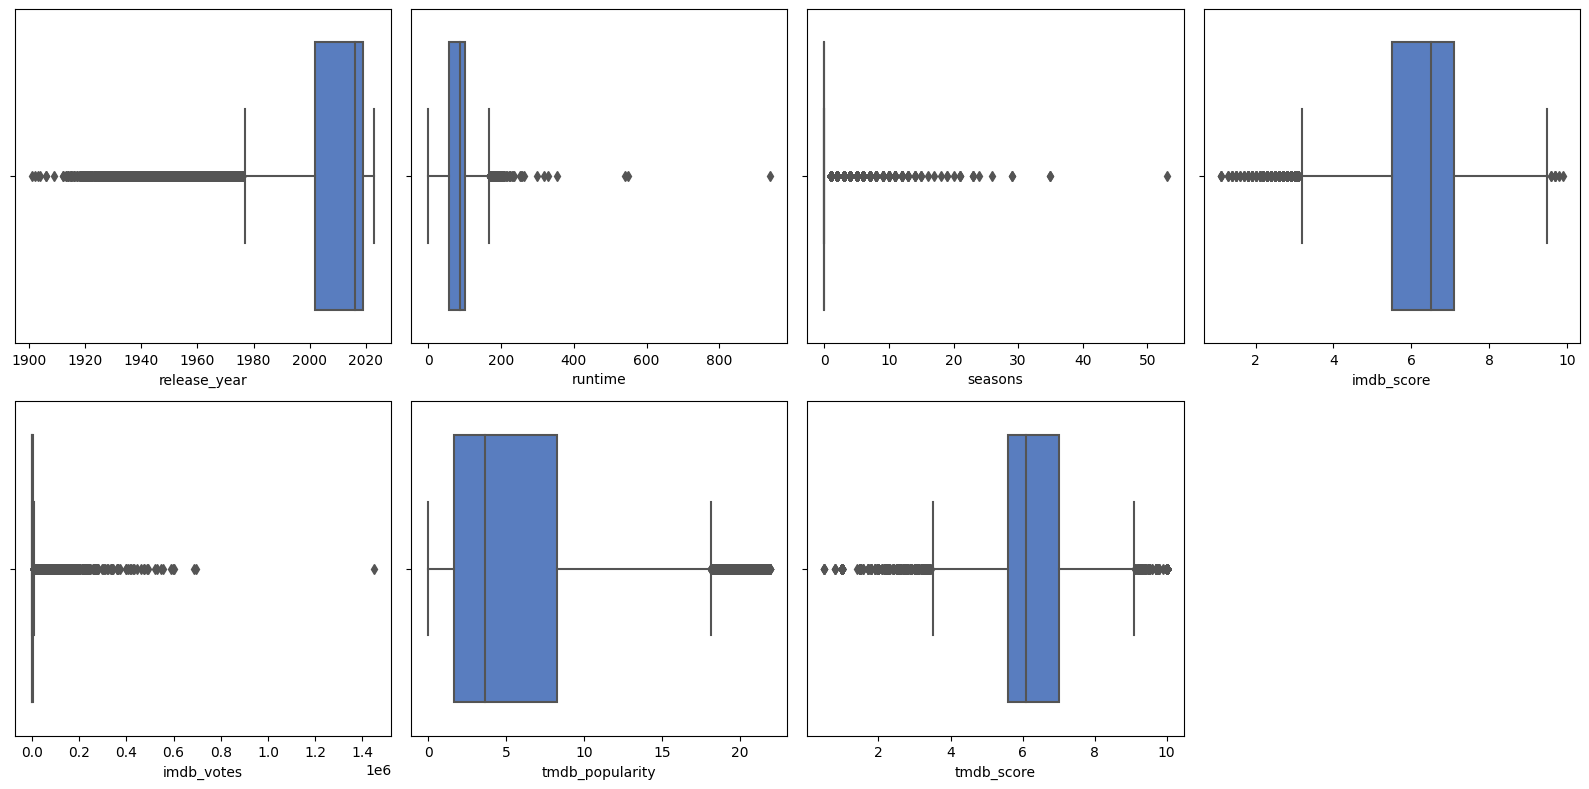

In [130]:
titles_features = titles.dtypes[titles.dtypes != 'object'].index
fig = plt.figure(figsize=(16, 8))
i = 1
for f in titles_features :
  plt.subplots_adjust(hspace=1)
  plt.tight_layout()
  plt.subplot(2,4,i)
  sns.boxplot(data=titles, x=titles[f], palette="muted")
  i += 1

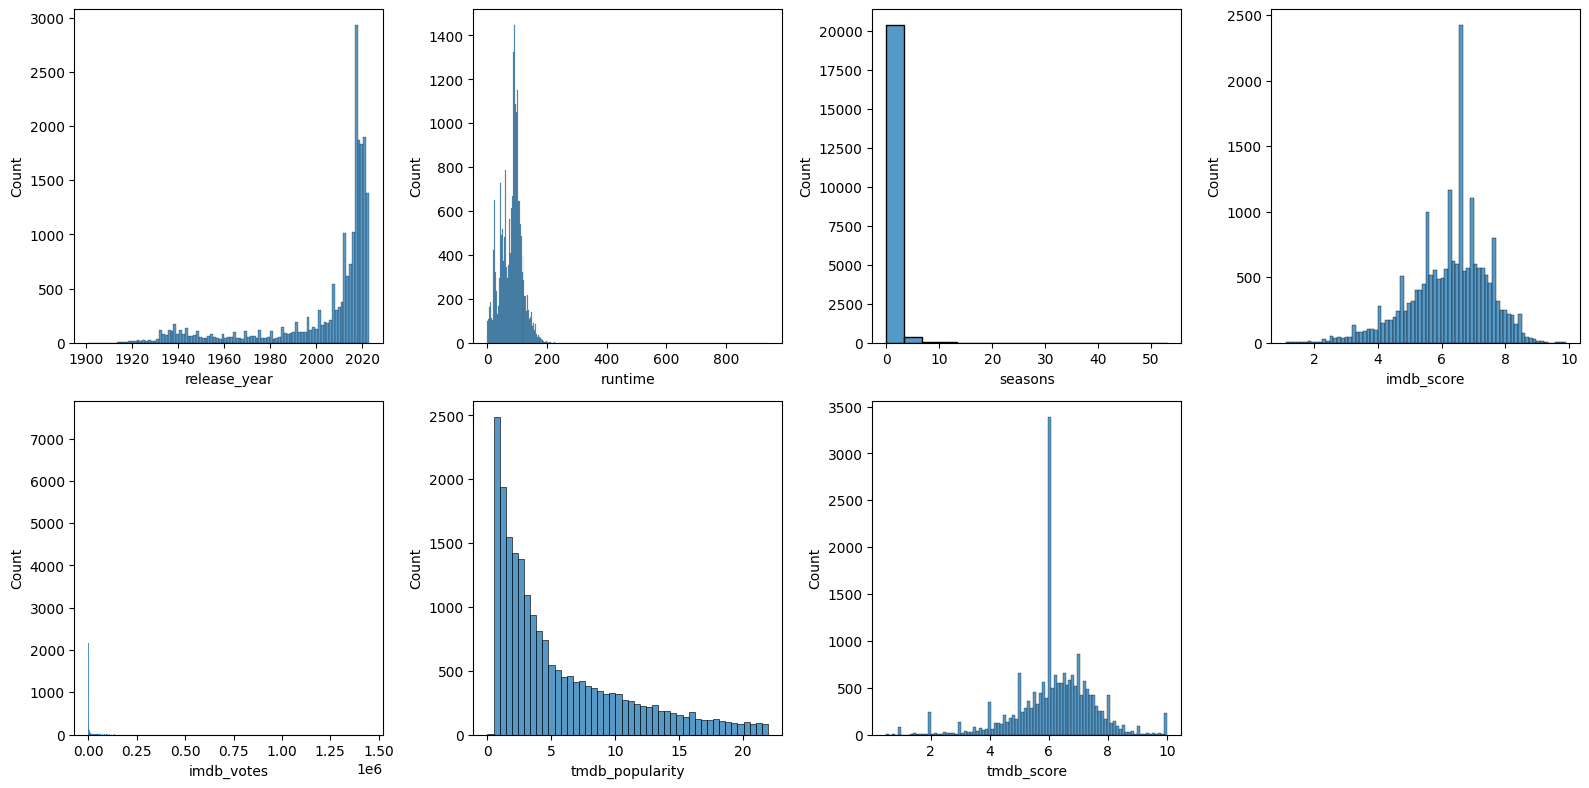

In [131]:
titles_features = titles.dtypes[titles.dtypes != 'object'].index
fig = plt.figure(figsize=(16, 8))
i = 1
for f in titles_features :
  plt.subplots_adjust(hspace=1)
  plt.tight_layout()
  plt.subplot(2,4,i)
  sns.histplot(data=titles, x=titles[f], palette="muted")
  i += 1

In [ ]:
show.corr()['tmdb_popularity'].sort_values(ascending=False)

tmdb_popularity    1.000000
imdb_votes         0.427641
seasons            0.202642
tmdb_score         0.156970
imdb_score         0.120402
runtime            0.034960
release_year      -0.064181
Name: tmdb_popularity, dtype: float64

<Axes: >

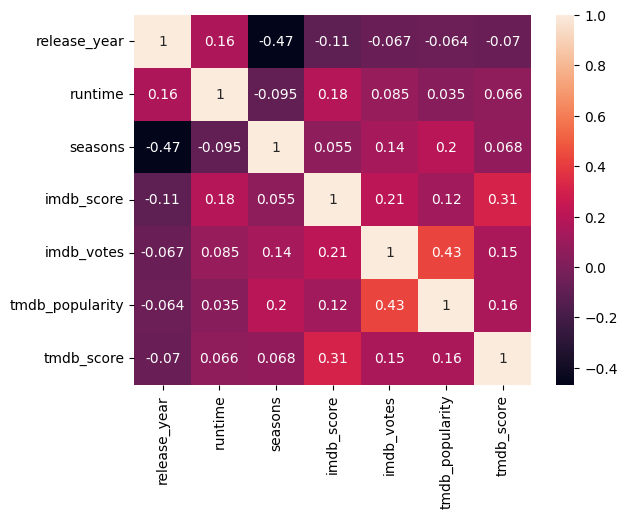

In [ ]:
sns.heatmap(show.corr(), annot=True)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'action'),
  Text(1, 0, 'animation'),
  Text(2, 0, 'comedy'),
  Text(3, 0, 'crime'),
  Text(4, 0, 'documentation'),
  Text(5, 0, 'drama'),
  Text(6, 0, 'european'),
  Text(7, 0, 'family'),
  Text(8, 0, 'fantasy'),
  Text(9, 0, 'history'),
  Text(10, 0, 'horror'),
  Text(11, 0, 'music'),
  Text(12, 0, 'reality'),
  Text(13, 0, 'romance'),
  Text(14, 0, 'scifi'),
  Text(15, 0, 'sport'),
  Text(16, 0, 'thriller'),
  Text(17, 0, 'war'),
  Text(18, 0, 'western')])

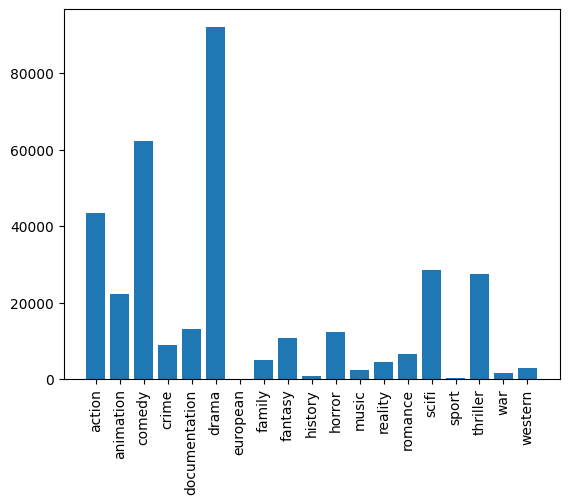

In [ ]:
x_movie = movie.groupby('genres')['tmdb_popularity'].sum().index
y_movie = []
for i in range(len(x)):
  ot = movie.groupby('genres')['tmdb_popularity'].sum()[i]
  y_movie.append(ot)

plt.bar(x, y)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'action'),
  Text(1, 0, 'animation'),
  Text(2, 0, 'comedy'),
  Text(3, 0, 'crime'),
  Text(4, 0, 'documentation'),
  Text(5, 0, 'drama'),
  Text(6, 0, 'european'),
  Text(7, 0, 'family'),
  Text(8, 0, 'fantasy'),
  Text(9, 0, 'history'),
  Text(10, 0, 'horror'),
  Text(11, 0, 'music'),
  Text(12, 0, 'reality'),
  Text(13, 0, 'romance'),
  Text(14, 0, 'scifi'),
  Text(15, 0, 'sport'),
  Text(16, 0, 'thriller'),
  Text(17, 0, 'war'),
  Text(18, 0, 'western')])

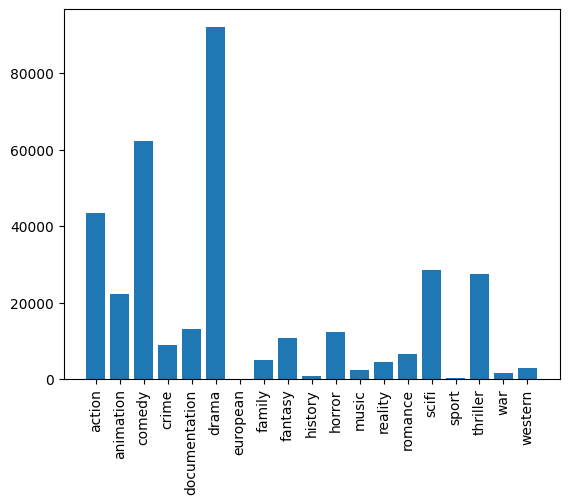

In [ ]:
x_show = show.groupby('genres')['tmdb_popularity'].sum().index
y_show = []
for i in range(len(x_show)):
  ot = show.groupby('genres')['tmdb_popularity'].sum()[i]
  y_show.append(ot)

plt.bar(x, y)
plt.xticks(rotation=90)

In [ ]:
movie = movie[(movie['imdb_votes'] < 1200000)]

In [ ]:
movie = movie[(movie['tmdb_popularity'] < 500)]

In [ ]:
movie = movie[(movie['runtime'] < 400)]

In [ ]:
movie = movie[(movie['tmdb_score'] > 1)]

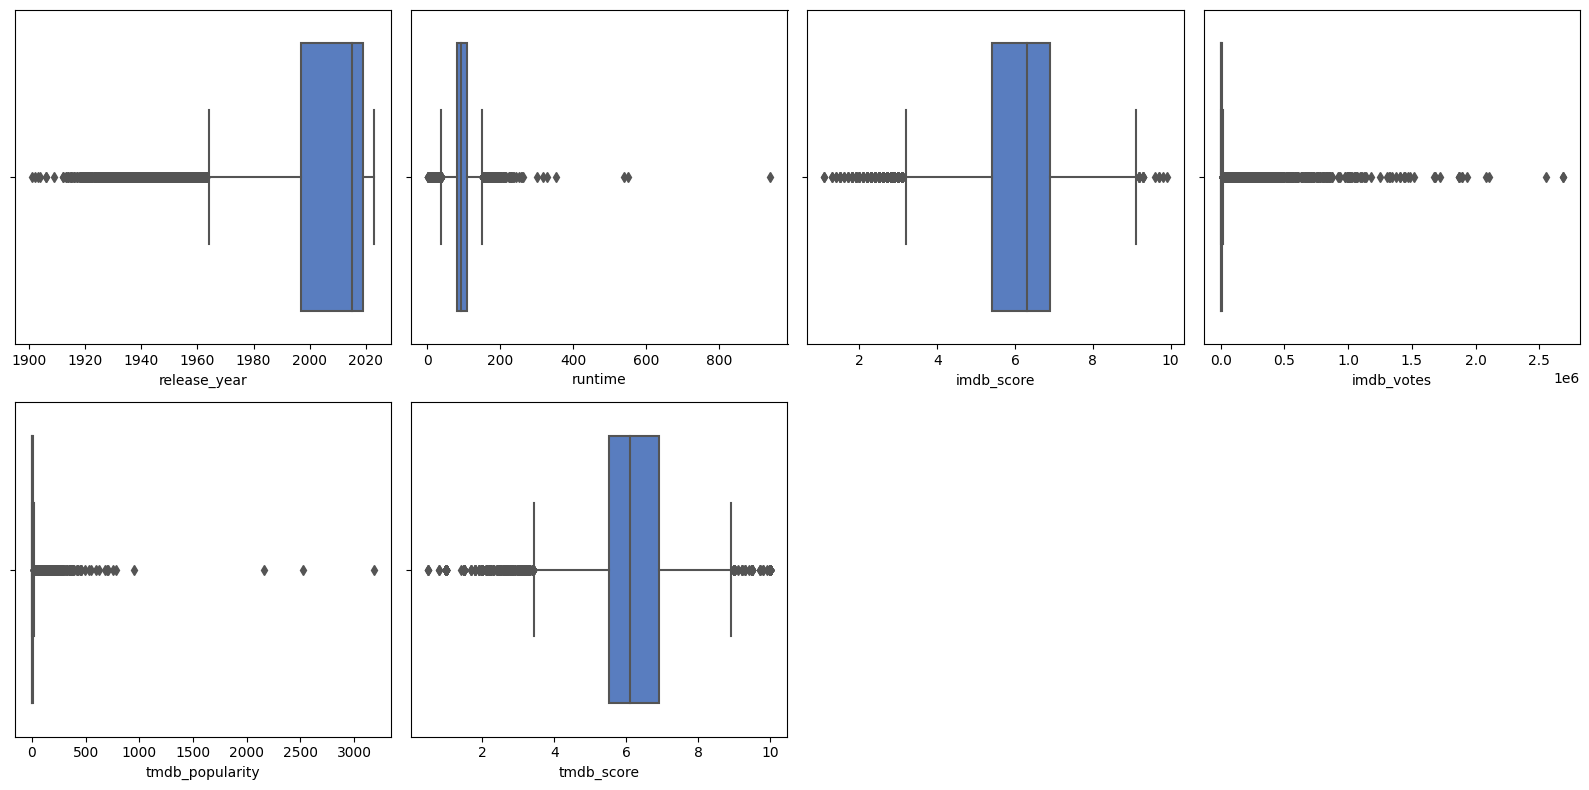

In [ ]:
movie_features = movie.dtypes[movie.dtypes != 'object'].index
fig = plt.figure(figsize=(16, 8))
i = 1
for f in movie_features :
  plt.subplots_adjust(hspace=1)
  plt.tight_layout()
  plt.subplot(2,4,i)
  sns.boxplot(data=movie, x=movie[f], palette="muted")
  i += 1

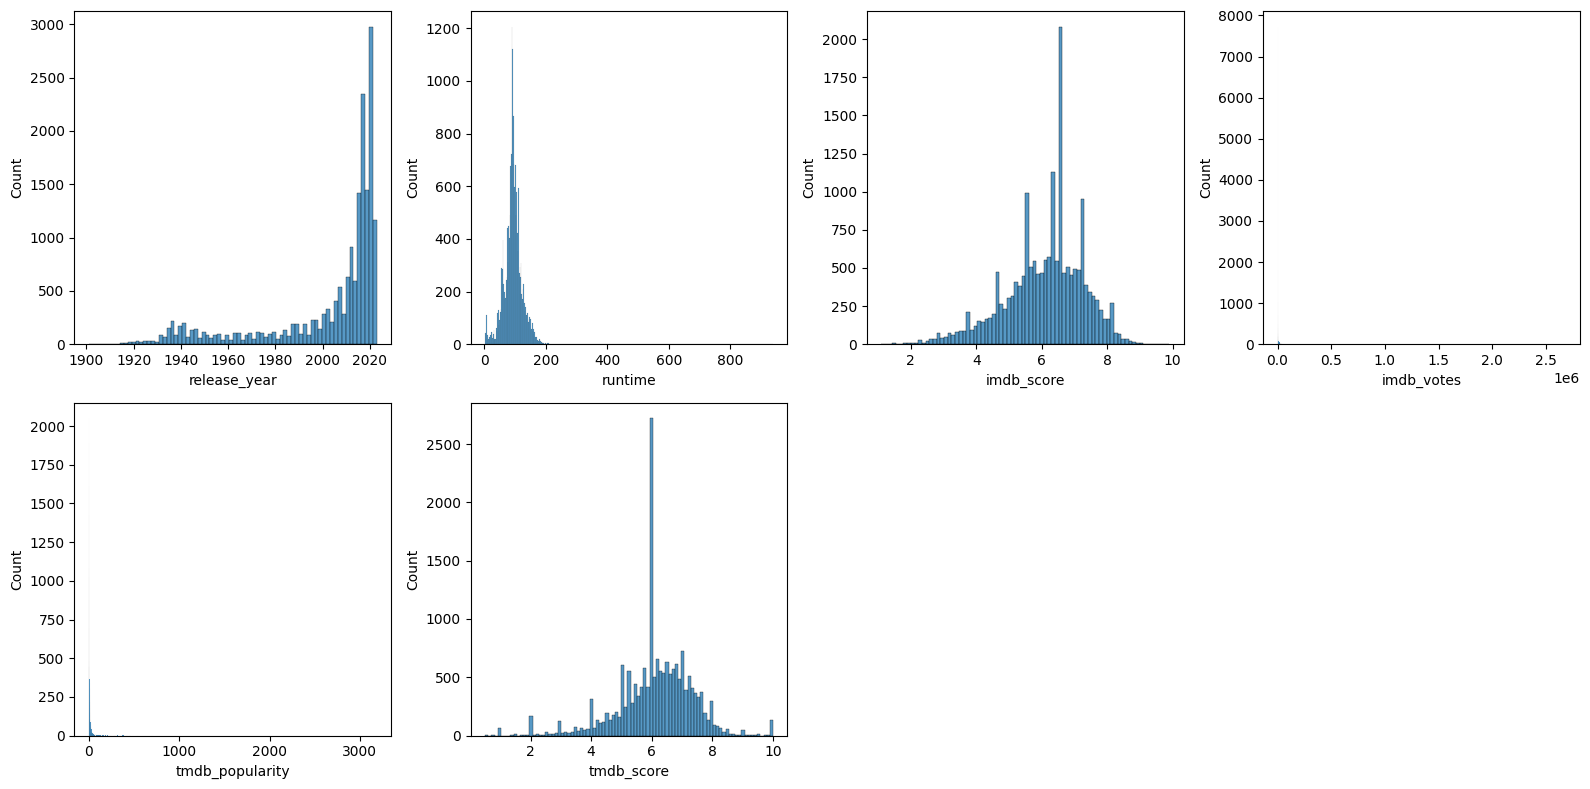

In [ ]:
movie_features = movie.dtypes[movie.dtypes != 'object'].index
fig = plt.figure(figsize=(16, 8))
i = 1
for f in movie_features :
  plt.subplots_adjust(hspace=1)
  plt.tight_layout()
  plt.subplot(2,4,i)
  sns.histplot(data=movie, x=movie[f], palette="muted")
  i += 1

In [ ]:
movie_features = movie.dtypes[movie.dtypes == 'object'].index
fig = plt.figure(figsize=(16, 8))
i = 1
for f in movie_features :
  plt.subplots_adjust(hspace=1)
  plt.tight_layout()
  plt.subplot(2,2,i)
  sns.histplot(data=movie, x=movie[f], palette="muted")
  plt.xticks(rotation=90)
  i += 1

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7f217d6b5700> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f217d727940> (for post_execute):


KeyboardInterrupt: ignored

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125],
 [Text(0, 0, 'US'),
  Text(1, 0, 'GB'),
  Text(2, 0, 'CA'),
  Text(3, 0, 'FR'),
  Text(4, 0, 'SE'),
  Text(5, 0, 'AU'),
  Text(6, 0, 'SK'),
  Text(7, 0, 'ES'),
  Text(8, 0, 'PL'),
  Text(9, 0, 'JP'),
  Text(10, 0, 'IN'),
  Text

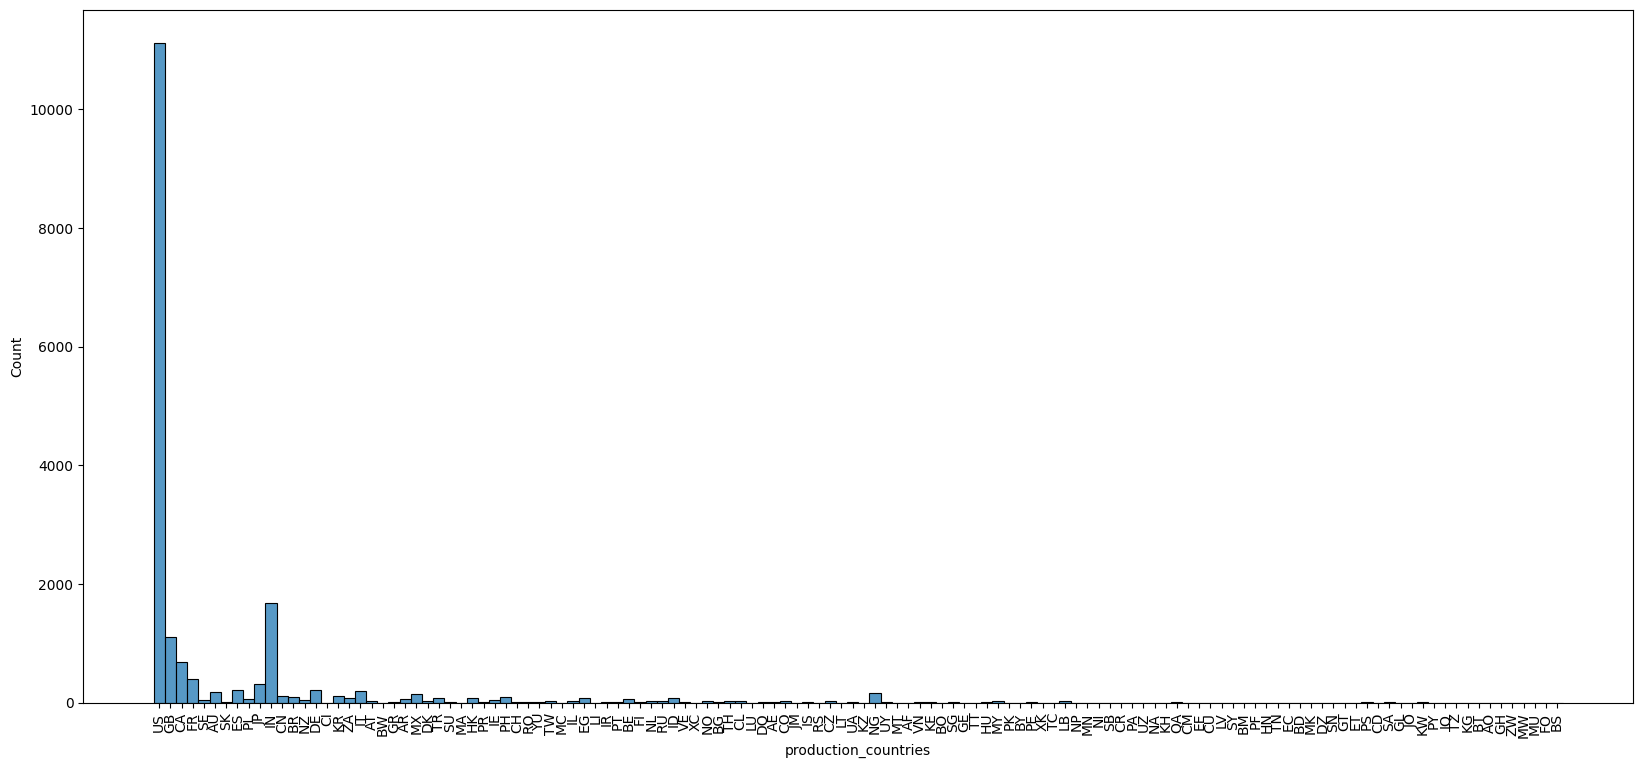

In [ ]:
plt.figure(figsize=(20, 9))
sns.histplot(movie['production_countries'])
plt.xticks(rotation=90)

<Axes: >

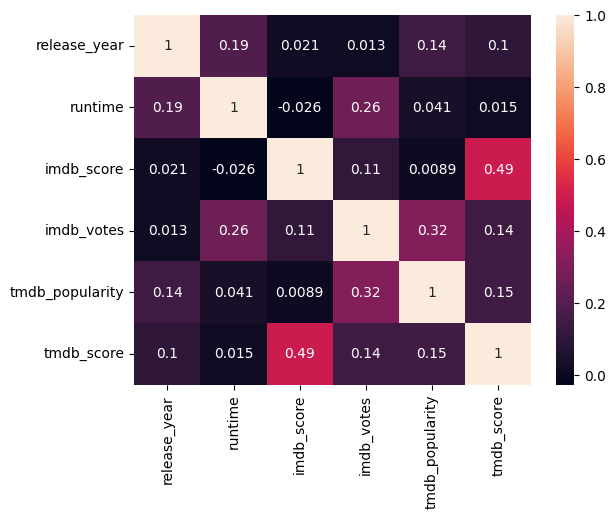

In [ ]:
movie.corr()['tmdb_popularity'].sort_values(ascending=False)
sns.heatmap(movie.corr(), annot=True)

In [ ]:
show = show[(show['tmdb_popularity'] < 112)]

In [ ]:
show = show[(show['runtime'] < 125)]

In [ ]:
show = show[(show['imdb_score'] > 2)]

In [ ]:
show = show[(show['tmdb_score'] > 1)]

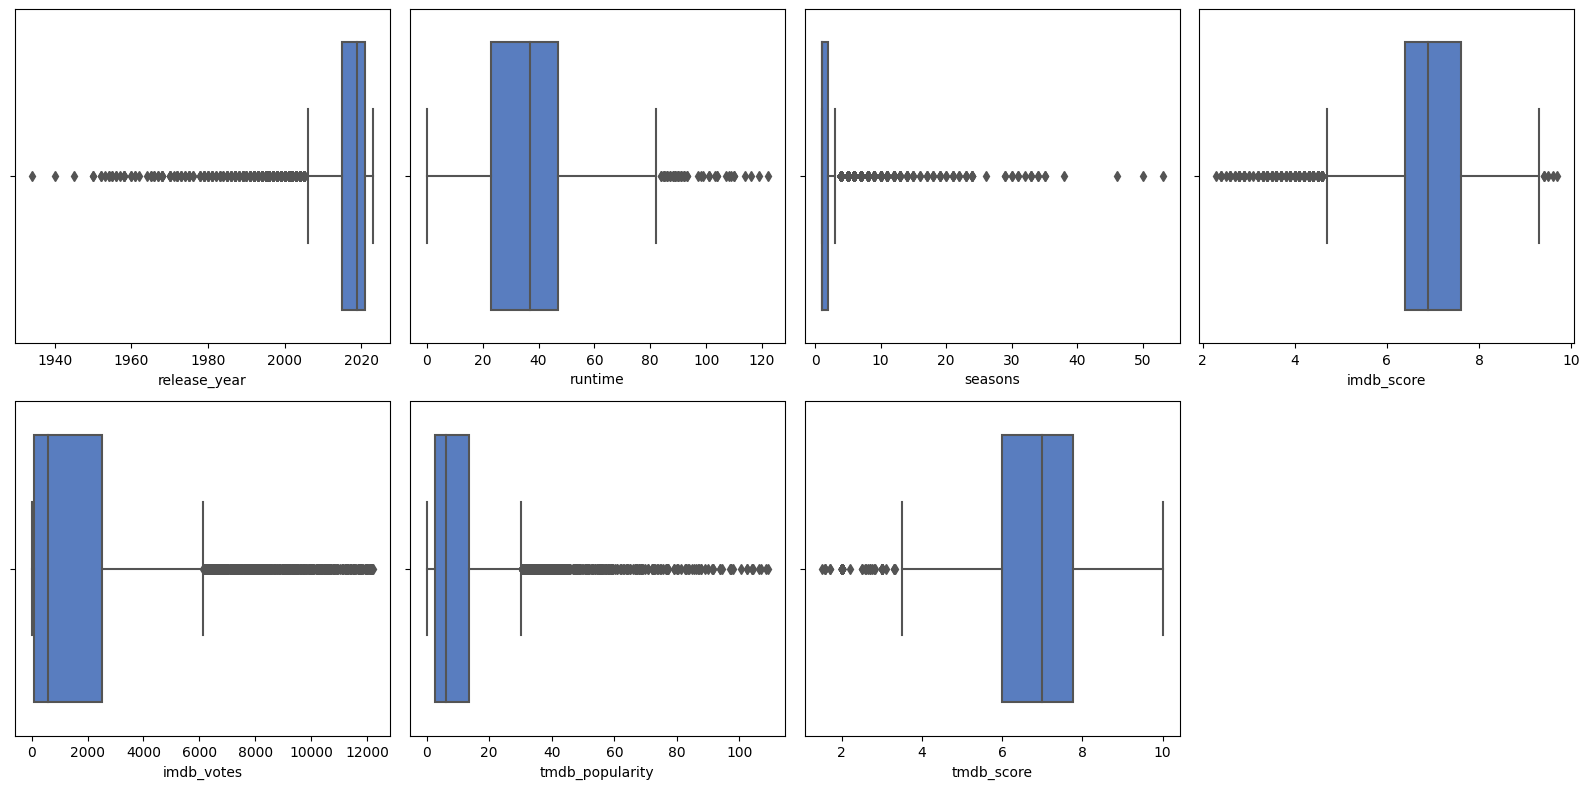

In [ ]:
show_features = show.dtypes[show.dtypes != 'object'].index
fig = plt.figure(figsize=(16, 8))
i = 1
for f in show_features :
  plt.subplots_adjust(hspace=1)
  plt.tight_layout()
  plt.subplot(2,4,i)
  sns.boxplot(data=show, x=show[f], palette="muted")
  i += 1

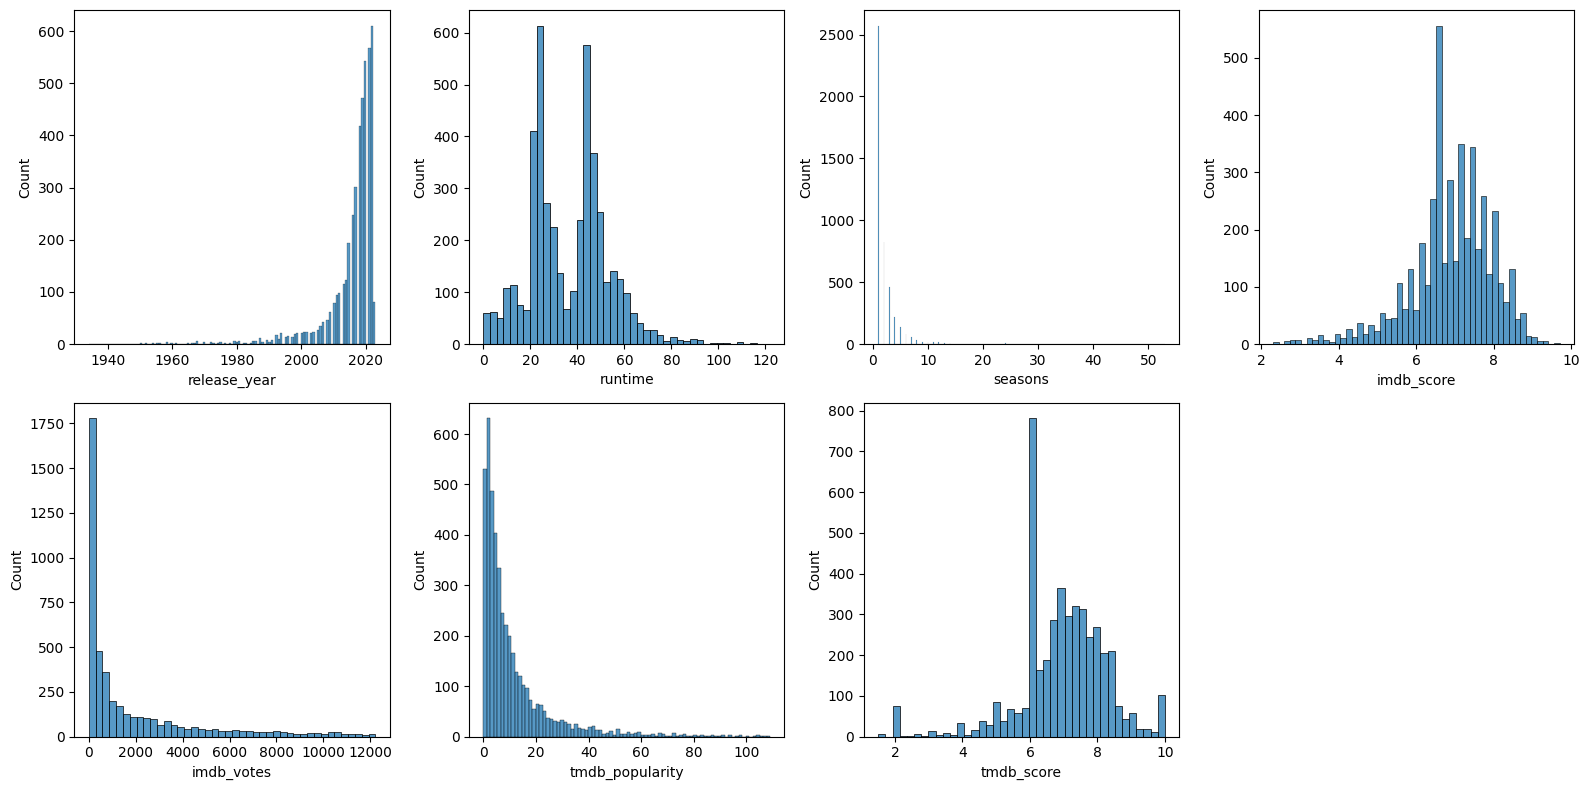

In [ ]:
show_features = show.dtypes[show.dtypes != 'object'].index
fig = plt.figure(figsize=(16, 8))
i = 1
for f in show_features :
  plt.subplots_adjust(hspace=1)
  plt.tight_layout()
  plt.subplot(2,4,i)
  sns.histplot(data=show, x=show[f], palette="muted")
  i += 1

In [ ]:
show_features = show.dtypes[show.dtypes == 'object'].index
fig = plt.figure(figsize=(16, 8))
i = 1
for f in show_features :
  plt.subplots_adjust(hspace=1)
  plt.tight_layout()
  plt.subplot(2,3,i)
  sns.histplot(data=show, x=show[f], palette="muted")
  plt.xticks(rotation=90)
  i += 1

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7f217d6b5700> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f217d727940> (for post_execute):


KeyboardInterrupt: ignored

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60],
 [Text(0, 0, 'US'),
  Text(1, 0, 'GB'),
  Text(2, 0, 'CA'),
  Text(3, 0, 'JP'),
  Text(4, 0, 'DE'),
  Text(5, 0, 'AR'),
  Text(6, 0, 'NL'),
  Text(7, 0, 'AE'),
  Text(8, 0, 'KR'),
  Text(9, 0, 'FR'),
  Text(10, 0, 'IT'),
  Text(11, 0, 'CO'),
  Text(12, 0, 'AU'),
  Text(13, 0, 'NZ'),
  Text(14, 0, 'CL'),
  Text(15, 0, 'PH'),
  Text(16, 0, 'IN'),
  Text(17, 0, 'ES'),
  Text(18, 0, 'TW'),
  Text(19, 0, 'MX'),
  Text(20, 0, 'BR'),
  Text(21, 0, 'CN'),
  Text(22, 0, 'PR'),
  Text(23, 0, 'RU'),
  Text(24, 0, 'CH'),
  Text(25, 0, 'DK'),
  Text(26, 0, 'IL'),
  Text(27, 0, 'IE'),
  Text(28, 0, 'ZA'),
  Text(29, 0, 'SG'),
  Text(30, 0, 'HU'),
  

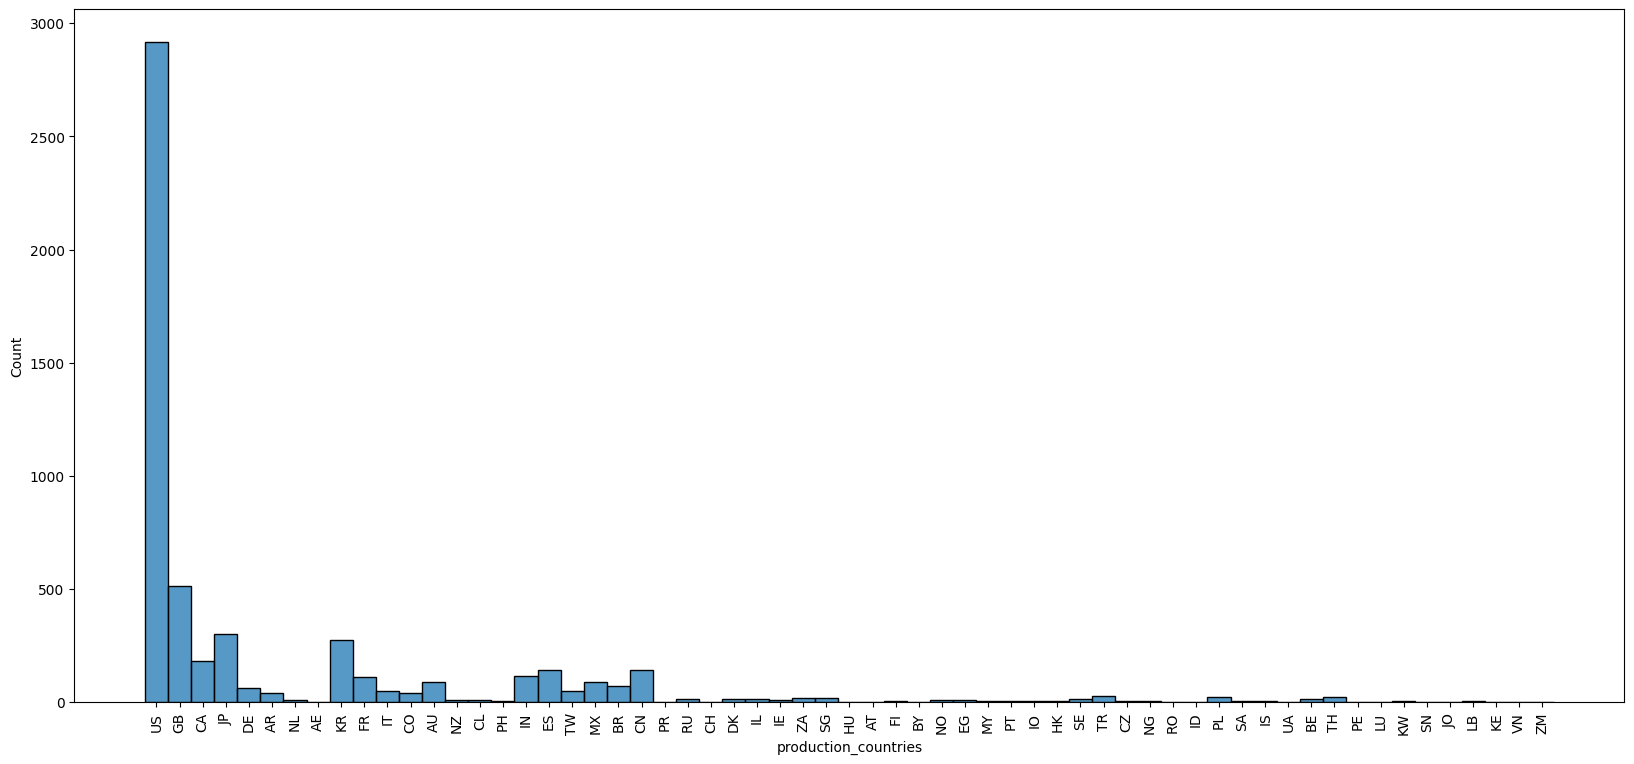

In [ ]:
plt.figure(figsize=(20, 9))
sns.histplot(show['production_countries'])
plt.xticks(rotation=90)

<Axes: >

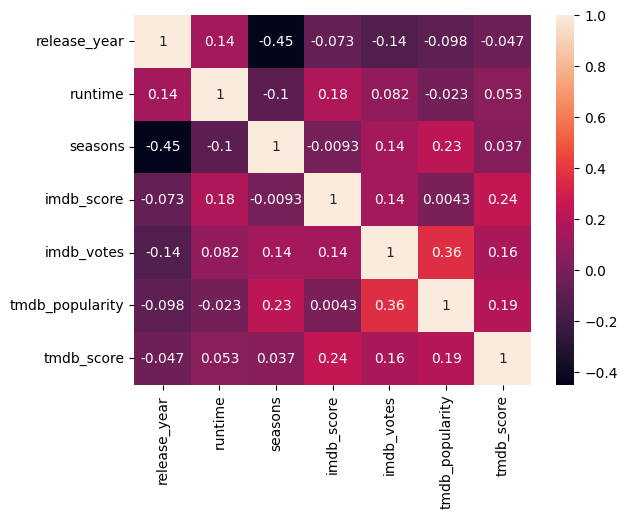

In [ ]:
show.corr()['tmdb_popularity'].sort_values(ascending=False)
sns.heatmap(show.corr(), annot=True)

In [58]:
target = 'tmdb_popularity'

X, y = titles.drop(target, axis=1), titles[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
target = 'tmdb_popularity'

X, y = titles1.drop(target, axis=1), titles1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [162]:
titles_real = titles['tmdb_popularity']

y_base = [titles['tmdb_popularity'].mean()] * len(titles)
mean_squared_error(titles_real, y_base)
r2_score(titles_real, y_base)

0.0

In [141]:
def eval_popul(y_real, y_pred):
  eval1 = mean_squared_error(y_real, y_pred)
  eval2 = r2_score(y_real, y_pred)

  return eval1, eval2

comparison = pd.DataFrame(index=['mse', 'r2'], columns=['Base', 'xgb', 'rand', 'ada'])
comparison['Base'] = eval_popul(titles_real, y_base)
comparison['xgb'] = eval_popul(y_train, pipe_pred)
comparison['rand'] = eval_popul(y_train, r_pipe_pred)
comparison['ada'] = eval_popul(y_train, ada_pipe_pred)

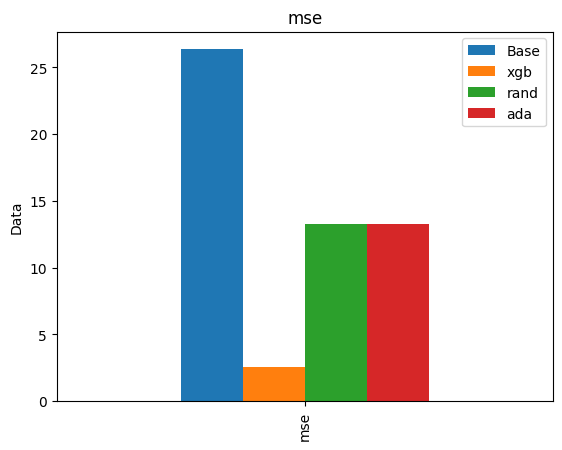

In [157]:
plt.figure(num='View matplot Chart')

plt.title("mse")
plt.ylabel("Data")
ax = plt.gca()
comparison[:1].plot(kind='bar', ax=ax)
plt.show()

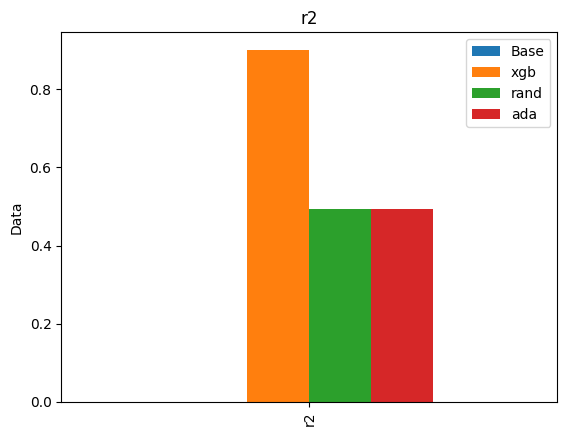

In [158]:
plt.figure(num='View matplot Chart')

plt.title("r2")
plt.ylabel("Data")
ax = plt.gca()
comparison[1:2].plot(kind='bar', ax=ax)
plt.show()

In [145]:
valid = pd.DataFrame(index=['mse', 'r2'], columns=['xgb', 'rand', 'ada'])
valid['xgb'] = eval_popul(y_val, pipe_val)
valid['rand'] = eval_popul(y_val, r_pipe_val)
valid['ada'] = eval_popul(y_val, ada_pipe_val)

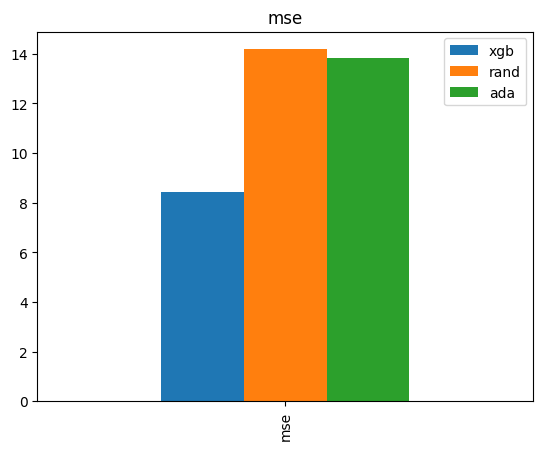

In [161]:
plt.figure(num='View matplot Chart')

plt.title("mse")
ax = plt.gca()
valid[:1].plot(kind='bar', ax=ax)
plt.show()

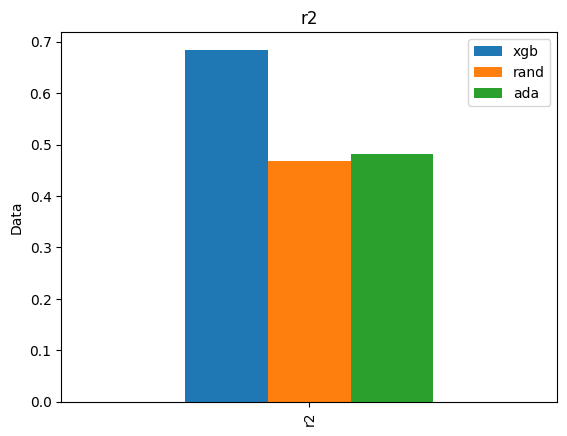

In [163]:
plt.figure(num='View matplot Chart')

plt.title("r2")
plt.ylabel("Data")
ax = plt.gca()
valid[1:2].plot(kind='bar', ax=ax)
plt.show()

In [148]:
valid

,xgb,rand,ada
mse,8.429022,14.183858,13.839955
r2,0.684297,0.468754,0.481635


In [60]:
def get_pipeline():
    return make_pipeline(
        OrdinalEncoder(),
        XGBRegressor(
            n_estimators=200,
            random_state=42,
            max_depth=6,
            reg_lambda=3,
            colsample_bytree=0.5,
            gamma=2,
            reg_alpha=2,
            

        ),
    )


pipe = get_pipeline()
pipe.fit(X_train, y_train)
pipe_pred = pipe.predict(X_train)
mean_squared_error(y_train, pipe_pred)

2.5828351547526376

In [61]:
r2_score(y_train, pipe_pred)

0.9013738086192487

In [62]:
pipe_val = pipe.predict(X_val)
mean_squared_error(y_val, pipe_val)

8.429021663304432

In [63]:
r2_score(y_val, pipe_val)

0.6842972220166149

In [64]:
pipe_test = pipe.predict(X_test)
mean_squared_error(y_test, pipe_test)

8.11335711517793

In [65]:
r2_score(y_test, pipe_test)

0.6950506878203604

In [169]:
def PolynomialRegression(degree=2):
    return make_pipeline(OrdinalEncoder(),
                         PolynomialFeatures(degree),
                         XGBRegressor(
                             n_estimators=200,
                             random_state=42,
                             max_depth=6,
                             reg_lambda=3,
                             colsample_bytree=0.5,
                             gamma=2,
                             reg_alpha=2,

        ),
    )


polynomial_degrees = [1, 2, 3]
train_r2s = []
test_r2s = []

for degree in polynomial_degrees:
    model = PolynomialRegression(degree)
    print(f'Degree={degree}')
    
    model.fit(X_train, y_train)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_val, y_val)
    display(HTML(f'<b style="color: blue">train R2 {train_r2:.2f}</b>'))
    display(HTML(f'<b style="color: red">test R2 {test_r2:.2f}</b>'))

 
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

Degree=1


Degree=2


Degree=3


In [135]:
def get_pipeline():
    return make_pipeline(
        OrdinalEncoder(),
        RandomForestRegressor(
            random_state=42,
            max_depth=6,
            min_samples_split=6,
            n_jobs=-1,
            ccp_alpha=0.7,
            oob_score=True

        ),
    )


r_pipe = get_pipeline()
r_pipe.fit(X_train, y_train)
r_pipe_pred = r_pipe.predict(X_train)
mean_squared_error(y_train, r_pipe_pred)

13.282583327415917

In [137]:
r2_score(y_train, r_pipe_pred)

0.49280131065663735

In [138]:
r_pipe_val = r_pipe.predict(X_val)
mean_squared_error(y_val, r_pipe_val)
r2_score(y_val, r_pipe_val)

0.46875406255144625

In [136]:
def get_pipeline():
    return make_pipeline(
        OrdinalEncoder(),
        AdaBoostRegressor(
            n_estimators=200,
            random_state=42,
        ),
    )

ada_pipe = get_pipeline()
ada_pipe.fit(X_train, y_train)
ada_pipe_pred = ada_pipe.predict(X_train)
mean_squared_error(y_train, ada_pipe_pred)

13.268082253330338

In [143]:
r2_score(y_train, ada_pipe_pred)

0.4933550377132633

In [144]:
ada_pipe_val = ada_pipe.predict(X_val)
mean_squared_error(y_val, ada_pipe_val)
r2_score(y_val, ada_pipe_val)

0.4816347134970258

In [ ]:
target = 'tmdb_popularity'

X_m, y_m = movie.drop(target, axis=1), movie[target]

X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_m, y_m, test_size=0.2, random_state=42)
X_m_train, X_m_val, y_m_train, y_m_val = train_test_split(X_m_train, y_m_train, test_size=0.2, random_state=42)

In [ ]:
X_s, y_s = show.drop(target, axis=1), show[target]

X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)
X_s_train, X_s_val, y_s_train, y_s_val = train_test_split(X_s_train, y_s_train, test_size=0.2, random_state=42)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133 entries, 97 to 892
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  1133 non-null   object 
 1   release_year          1133 non-null   int64  
 2   age_certification     1133 non-null   object 
 3   runtime               1133 non-null   int64  
 4   genres                1133 non-null   object 
 5   production_countries  1133 non-null   object 
 6   seasons               1133 non-null   float64
 7   imdb_score            1133 non-null   float64
 8   imdb_votes            1133 non-null   float64
 9   tmdb_score            1133 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 97.4+ KB


In [ ]:
X_train.drop('tmdb_score', axis=1, inplace=True), X_val.drop('tmdb_score', axis=1, inplace=True), X_test.drop('tmdb_score', axis=1, inplace=True)

(None, None, None)

In [ ]:
encode = OrdinalEncoder()
X_m_train_encoded = encode.fit_transform(X_m_train)
X_m_val_encoded = encode.transform(X_m_val)
X_m_test_encoded = encode.transform(X_m_test)
X_s_train_encoded = encode.fit_transform(X_s_train)
X_s_val_encoded = encode.transform(X_s_val)
X_s_test_encoded = encode.transform(X_s_test)

In [ ]:
movie_real = movie['tmdb_popularity']

y_m_base = [movie['tmdb_popularity'].mean()] * len(movie)
mean_squared_error(movie_real, y_m_base)

1977.840072926278

In [ ]:
show_real = show['tmdb_popularity']

y_s_base = [show['tmdb_popularity'].mean()] * len(show)
mean_squared_error(show_real, y_s_base)

6317.410042629656

In [ ]:
def get_pipeline():
    return make_pipeline(
        OrdinalEncoder(),
        XGBRegressor(
            random_state=42,
            max_depth=6,
            reg_lambda=3,
            colsample_bytree=0.5,
            gamma=2,
            reg_alpha=0.8,
            

        ),
    )


xgb_pipe = get_pipeline()
xgb_pipe.fit(X_m_train, y_m_train)
xgb_pipe_pred = xgb_pipe.predict(X_m_train)
mean_squared_error(y_m_train, xgb_pipe_pred)

90.61960558024717

In [ ]:
r2_score(y_m_train, xgb_pipe_pred)

0.9572155305262721

In [ ]:
xgb_pipe_val = xgb_pipe.predict(X_m_val)
mean_squared_error(y_m_val, xgb_pipe_val)

1647.6533420930311

In [ ]:
r2_score(y_m_val, xgb_pipe_val)

0.2154095613759791

In [ ]:
def get_pipeline():
    return make_pipeline(
        OrdinalEncoder(),
        RandomForestRegressor(
            random_state=42,

        ),
    )


rfr_pipe = get_pipeline()
rfr_pipe.fit(X_m_train, y_m_train)
rfr_pipe_pred = rfr_pipe.predict(X_m_train)
mean_squared_error(y_m_train, rfr_pipe_pred)

275.45141223813215

In [ ]:
r2_score(y_m_train, rfr_pipe_pred)

0.869950410146494

In [ ]:
rfr_pipe_val = rfr_pipe.predict(X_m_val)
mean_squared_error(y_m_val, rfr_pipe_val)

1985.8463912454476

In [ ]:
r2_score(y_m_val, rfr_pipe_val)

0.05436656404437934

In [ ]:
def get_pipeline():
    return make_pipeline(
        OrdinalEncoder(),
        XGBRegressor(
            random_state=42,

        ),
    )


s_xgb_pipe = get_pipeline()
s_xgb_pipe.fit(X_s_train, y_s_train)
s_xgb_pipe_pred = s_xgb_pipe.predict(X_s_train)
mean_squared_error(y_s_train, s_xgb_pipe_pred)

38.16848490241234

In [ ]:
r2_score(y_s_train, s_xgb_pipe_pred)

0.9928742958590456

In [ ]:
s_xgb_pipe_val = s_xgb_pipe.predict(X_s_val)
mean_squared_error(y_s_val, s_xgb_pipe_val)

1254.987747855

In [ ]:
r2_score(y_s_val, s_xgb_pipe_val)

0.491833207158864

In [ ]:
def get_pipeline():
    return make_pipeline(
        OrdinalEncoder(),
        RandomForestRegressor(
            random_state=42,

        ),
    )


s_rfr_pipe = get_pipeline()
s_rfr_pipe.fit(X_s_train, y_s_train)
s_rfr_pipe_pred = s_rfr_pipe.predict(X_s_train)
mean_squared_error(y_s_train, s_rfr_pipe_pred)

467.17314813375316

In [ ]:
r2_score(y_s_train, s_rfr_pipe_pred)

0.9127830815210333

In [ ]:
s_rfr_pipe_val = s_rfr_pipe.predict(X_s_val)
mean_squared_error(y_s_val, s_rfr_pipe_val)

1408.4254144565627

In [ ]:
r2_score(y_s_val, s_rfr_pipe_val)

0.42970357515949853

In [ ]:
pipe_val = pipe.predict(X_m_val)
mean_absolute_error(y_m_val, pipe_val)

6.705783060792359

In [ ]:
pipe_test = pipe.predict(X_m_test)
mean_absolute_error(y_m_test, pipe_test)

6.959155848239995

In [ ]:
pipe_s_val = show_pipe.predict(X_s_val)
mean_squared_error(y_s_val, pipe_s_val)

1366.56700016815

In [ ]:
r2_score(y_s_val, pipe_s_val)

0.511570227433664

In [ ]:
pipe.named_steps

{'ordinalencoder': OrdinalEncoder(cols=['type', 'age_certification', 'genres',
                      'production_countries', 'platform'],
                mapping=[{'col': 'type', 'data_type': dtype('O'),
                          'mapping': MOVIE    1
 NaN     -2
 dtype: int64},
                         {'col': 'age_certification', 'data_type': dtype('O'),
                          'mapping': PG-13    1
 PG       2
 R        3
 G        4
 NC-17    5
 NaN     -2
 dtype: int64},
                         {'col': 'genres', 'data_type': dtype('O'),
                          'mapping': drama             1
 documentation     2
 comedy            3
 horro...
 romance           8
 music             9
 thriller         10
 western          11
 scifi            12
 fantasy          13
 crime            14
 history          15
 war              16
 sport            17
 european         18
 reality          19
 NaN              -2
 dtype: int64},
                         {'col': 'production_countr

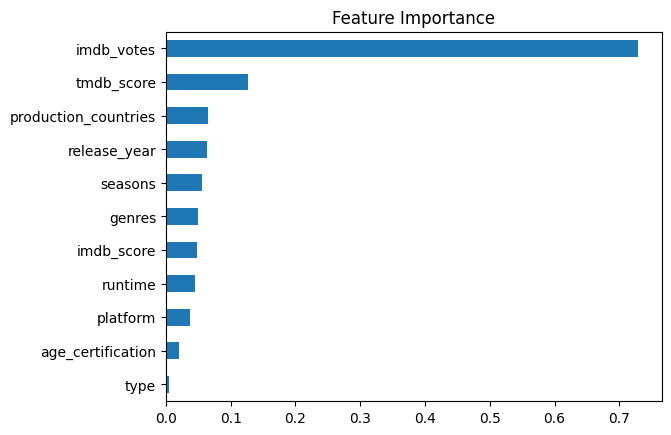

imdb_votes 0.7290692796002074
tmdb_score 0.12664897996273336
production_countries 0.06487223059931999
release_year 0.06298508127063808
seasons 0.055143268129529376
genres 0.05011987322291097
imdb_score 0.04820893007353146
runtime 0.045037473745565125
platform 0.03707887102167392
age_certification 0.020379321223312964
type 0.004934062365030567
['imdb_votes', 'tmdb_score', 'production_countries', 'release_year', 'seasons', 'genres', 'imdb_score', 'runtime', 'platform', 'age_certification', 'type']


In [168]:
permuter = PermutationImportance(
    pipe.named_steps["xgbregressor"],  # model
    scoring="r2",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=42,
)

# 스코어를 다시 계산합니다.
pipe.fit(X_train, y_train)
X_val_preprocessed = pipe[0].transform(X_val)
permuter.fit(X_val_preprocessed, y_val)

feature_names = X_val.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)
prior_index = []

pi.sort_values().plot.barh()
plt.title("Feature Importance")
plt.show()

for i in pi.index:
  if pi[i] > 0:
    prior_index.append(i)
    print(i, pi[i])

print(prior_index)

In [ ]:
pipe.fit(X_train[prior_index], y_train)
pipe_val = pipe.predict(X_val[prior_index])
test_score = mean_absolute_error(y_val, pipe_val)
test_score

1.9405077732236853

In [ ]:
r2_score(y_val, pipe_val)

0.6775316451471829

(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <Axes: >, 'pdp_ax': <Axes: xlabel='imdb_votes'>})

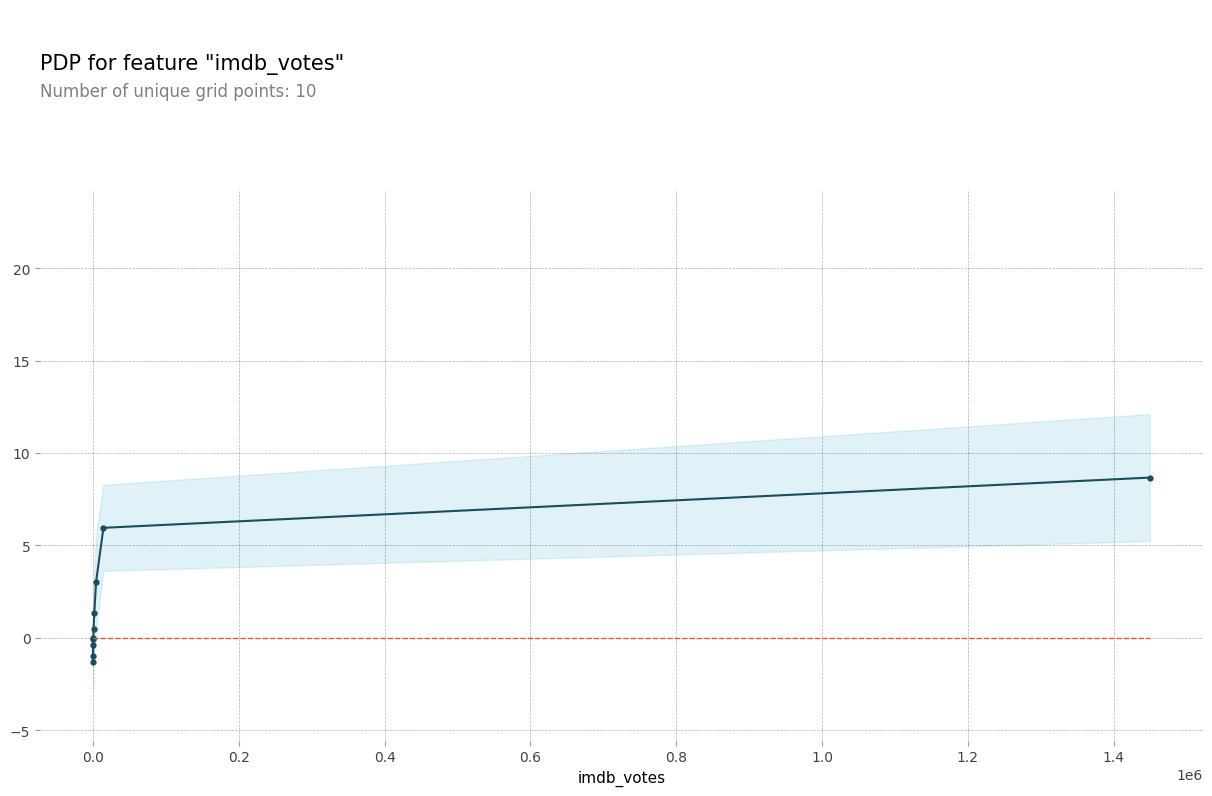

In [170]:
target_feature = 'imdb_votes'

isolated = pdp_isolate(
    model=pipe,
    dataset=X_val,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)